<a href="https://colab.research.google.com/github/aibijq/skku_gsb/blob/main/%ED%87%B4%EC%A7%81%EC%9E%90%EC%98%88%EC%B8%A1_XGB_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Package Load

In [1]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# 1.DataLoad & Preprocessing

In [2]:
# Google Drive 마운트
drive.mount('/content/drive')
path = "/content/drive/MyDrive/AIMBA"
# CSV 파일 로드
file_path = path + "/HR Attrition Data.csv"
df = pd.read_csv(file_path)

Mounted at /content/drive


In [3]:
# 결측치 확인
df.isnull().sum()
# 전처리
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df
# 데이터와 레이블 분리
X = numeric_df.drop('Attrition', axis=1)
y = numeric_df['Attrition']
# 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Feature Selection

In [4]:
# 로지스틱 회귀 모델생성
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Feature Selection (liblinear)
selector = SelectFromModel(estimator=model, prefit=True)
X_new = selector.transform(X)

# 선택된 Feature 출력
selected_features = pd.DataFrame(selector.inverse_transform(X_new),
                                 index=X.index,
                                 columns=X.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]
print('Selected features: ', selected_columns)

Selected features:  Index(['EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction',
       'NumCompaniesWorked', 'StockOptionLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


# 3. Modeling (XGB, GridSearch)

In [5]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# XGBoost 분류기 생성
model = XGBClassifier()

# 파라미터 그리드 생성
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
    'objective': ['binary:logistic'],
    'n_estimators': [50, 100, 150, 200]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(model, param_grid, cv=5)

# GridSearchCV 수행
grid_search.fit(X_train, y_train)

# 최적의 파라미터 출력
print("Best parameters: ", grid_search.best_params_)

# 최적의 모델 출력
print("Best model: ", grid_search.best_estimator_)

# 최적의 파라미터로 모델 생성
best_model = XGBClassifier(**grid_search.best_params_)

# 훈련
best_model.fit(X_train, y_train)

# 예측
preds = best_model.predict(X_test)

# 예측값을 이진 레이블로 변환
preds = [1 if value > 0.5 else 0 for value in preds]

Best parameters:  {'eta': 0.1, 'max_depth': 3, 'n_estimators': 50, 'objective': 'binary:logistic'}
Best model:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)


# 4.Evaluation

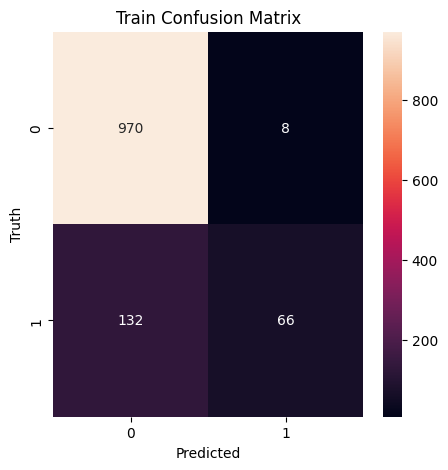

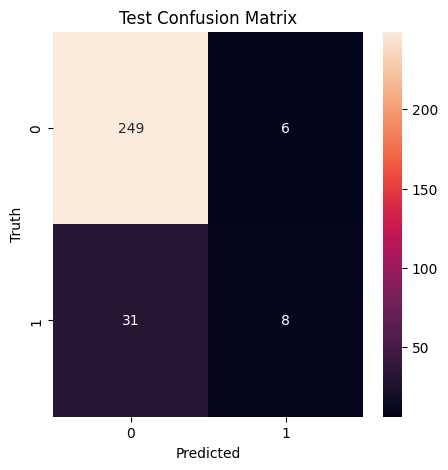


Train Accuracy: 88.10%

Test Accuracy: 87.41%


In [8]:
# 예측
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# 예측값을 이진 레이블로 변환
train_preds = [1 if value > 0.5 else 0 for value in train_preds]
test_preds = [1 if value > 0.5 else 0 for value in test_preds]

# Confusion Matrix 생성
train_cm = confusion_matrix(y_train, train_preds)
test_cm = confusion_matrix(y_test, test_preds)

# Confusion Matrix 시각화
plt.figure(figsize=(5,5))
sns.heatmap(train_cm, annot=True, fmt='d')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

plt.figure(figsize=(5,5))
sns.heatmap(test_cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# 정확도 출력
print("\nTrain Accuracy: %.2f%%" % (train_accuracy * 100.0))
print("\nTest Accuracy: %.2f%%" % (test_accuracy * 100.0))